# Venmo

## Graph and data generation module ##

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=4 
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=4

In [2]:
import sys, time, random
import numpy as np
import pandas as pd
from collections import Counter, defaultdict, deque
from datetime import datetime
from model.MNLogit_bfgs_torch import MNLogit

In [3]:
PATH = "../venmo/temp/"
def get_edges():
  l = []
  for i, filename in enumerate(sorted(os.listdir(PATH))):
    if '.list' not in filename:
      continue
    if i > 100:
      break
    dat = pd.read_csv(PATH + filename, delim_whitespace=True, header=None).values
    for row in dat:
      if row[3] == 0:
        l.append((row[2],row[4]))
      else:
        l.append((row[4],row[2]))
  return l

In [4]:
def flatten(l):
  return deque([i for j in l for i in j])

In [5]:
"""
  Define random_integer_excluding
  
    Params:
      low, high: integers indicating the range for sampling. Inclusive low and exclusive high.
      excluding: a set
  
    Functionality:
      Extend random.sample function to sample from large integer range, and exclude a small set
      Optimized when the range (high-low) is very large
      
    Return:
      sampled_integers (list)
"""
def random_integer_excluding(low, high, excluding, size=1):
  exclusion = {num for num in excluding if low <= num < high}
  result = []
  if size == 0:
    return result
  while len(result) < size:
    buf = random.sample(range(low, high), size - len(result))
    for num in buf:
      if len(exclusion) >= high-low:
        raise RuntimeError("random_integer_excluding fails: Size too large; exhausted all integers available in the range before finishing.")
      if num not in exclusion:
        result.append(num)
        exclusion.add(num)
  return result

In [6]:
def collect(assignment):
  result = defaultdict(set)
  for node in assignment:
    result[assignment[node]].add(node)
  return result

In [7]:
"""
  Define stratification_indexer
  
    Params: 
    - groups (an map from group_id to list of member)
      groups[i] return members of group i.
      Group 0 is the 'default' group and is not present.
      Can be negative, which will always be ignored.
    - strata_sizes (an integer array of length = number of strata)
      strata_sizes[i] return the size cap of the stratum i (except i=0)
    - num_multisample (an integer)
    
    Functionality:
      Perform sampling on the same set of parameters num_multisample time.
      In general case, sample strata_sizes[i] nodes from group i w/o replacement.
      
      If the specified strata_size[i] is larger than the number of nodes in group i,
      retuen all nodes in group i, and increase the number of sample in the default
      strata (group 0) with strata_size[i] - actual size of group[i].
      
    Return:
      sampled_nodes, (numpy.ndarray)
      log_down_sampling_rate for each sampled node, (numpy.ndarray)
"""
def stratification_indexer(num_nodes, groups_assignment, strata_sizes, post_assignments={}, num_multisample=1):
  
  num_strata = len(strata_sizes)
  groups = collect(groups_assignment)
  sizeof_pool0 = num_nodes - sum([len(groups[i]) for i in groups])
  
  def sample_once():
    
    sizeof_strata0 = strata_sizes[0]
    selected_indices_for_strata = [None] * num_strata
    
    for i in range(1, num_strata):
      selected_indices_for_strata[i] = random.sample(groups[i], min(len(groups[i]), strata_sizes[i]))
      sizeof_strata0 += strata_sizes[i] - len(selected_indices_for_strata[i])
    
    selected_indices_for_strata[0] = random_integer_excluding(low=0, high=num_nodes, excluding=groups_assignment, size=sizeof_strata0)
    actual_strata_sizes = [sizeof_strata0]
    pool_sizes = [sizeof_pool0]
    
    for i in range(1, num_strata):  
      actual_strata_sizes.append(len(selected_indices_for_strata[i]))
      pool_sizes.append(len(groups[i]))
 
    for n in post_assignments:
      actual_strata_sizes[post_assignments[n]] += 1
      pool_sizes[post_assignments[n]] += 1
      
    
    nested_strata_sizes = [[actual_strata_sizes[i]] * len(selected_indices_for_strata[i]) for i in range(num_strata)]
    nested_pool_sizes = [[pool_sizes[i]] * len(selected_indices_for_strata[i]) for i in range(num_strata)]
    
    for n in post_assignments:
      selected_indices_for_strata.append([n])
      nested_strata_sizes.append([actual_strata_sizes[post_assignments[n]]])
      nested_pool_sizes.append([pool_sizes[post_assignments[n]]])
    
    return flatten(selected_indices_for_strata), flatten(nested_strata_sizes), flatten(nested_pool_sizes)
  
  return [sample_once() for _ in range(num_multisample)]

In [8]:
def test():
  groups_assignment = {0:-1, 1:-1, 2:1, 3:1, 4:1, 5:2, 6:2}
  strata_sizes = np.array([0,2,1])
  return stratification_indexer(7, groups_assignment, strata_sizes, post_assignments={1:1}, num_multisample=2)
test()

[(deque([3, 4, 5, 1]), deque([3, 3, 1, 3]), deque([4, 4, 2, 4])),
 (deque([3, 4, 6, 1]), deque([3, 3, 1, 3]), deque([4, 4, 2, 4]))]

In [9]:
def test():
  groups_assignment = {0:-1, 1:-1, 2:1, 3:1, 4:1, 5:2, 6:2}
  strata_sizes = np.array([1,2,3])
  return stratification_indexer(9, groups_assignment, strata_sizes, post_assignments={1:2}, num_multisample=2)
test()

[(deque([8, 7, 3, 4, 6, 5, 1]),
  deque([2, 2, 2, 2, 3, 3, 3]),
  deque([2, 2, 3, 3, 3, 3, 3])),
 (deque([8, 7, 3, 4, 6, 5, 1]),
  deque([2, 2, 2, 2, 3, 3, 3]),
  deque([2, 2, 3, 3, 3, 3, 3]))]

In [10]:
class DirectedColorGraphFeatureExtractor(object):
  
  def __init__(self, num_nodes, num_multisample, graph_info=None):
    self.num_nodes = num_nodes
    self.adjacency_to = [Counter() for _ in range(num_nodes)]
    self.adjacency_from = [Counter() for _ in range(num_nodes)]
    self.in_degs = np.zeros(num_nodes)
    self.out_degs = np.zeros(num_nodes)
    self.graph_info = graph_info
    self.num_multisample = num_multisample
    self.data = {i:[[] for _ in range(num_multisample)] for i in ['Xs_u', 'ys_u', 'sws_u',
                                                                  'Xs_s', 'ys_s', 'sws_s']}
    
  def add_edge(self, actor, target):
    self.out_degs[actor] += 1
    self.in_degs[target] += 1
    self.adjacency_to[actor][target] += 1
    self.adjacency_from[target][actor] += 1
      
  
  def uniform_sample(self, actor, target, num_neg, num_multisample=1):
    # Exclude actor, target, those already connected
    assignment = {}
    assignment[actor] = -1
    assignment[target] = -1
    return stratification_indexer(self.num_nodes, assignment, [num_neg], post_assignments={target:0}, num_multisample=num_multisample)
  
    
  def stratified_sample(self, actor, target, num_neg, num_multisample=1):
    assignment = defaultdict(int)

    for n in self.adjacency_to[actor]:
      for nn in self.adjacency_to[n]:
        assignment[nn] = 2
      
    for friend in self.adjacency_to[actor]:
      assignment[friend] = 1
      
    target_group = assignment[target]
    
    assignment[actor] = -1
    assignment[target] = -1
    
    return stratification_indexer(self.num_nodes, assignment, [num_neg//3, num_neg//3, num_neg//3], post_assignments={target:target_group}, num_multisample=num_multisample) 
    
  def extract_feature(self, actor, candidates):
  
    in_degs = self.in_degs[candidates]
    out_degs = self.out_degs[candidates]
    payer_to_candidate = np.array([self.adjacency_to[actor][c] for c in candidates])
    candidate_to_payer = np.array([self.adjacency_from[actor][c] for c in candidates])
    
    path2_count = Counter()
    
    for n in self.adjacency_to[actor]:
      for nn in self.adjacency_to[n]:
        path2_count[nn] += 1
        
    num_path2 = np.array([path2_count[c] for c in candidates])
    
    return [in_degs, out_degs, payer_to_candidate, candidate_to_payer, num_path2]
  
  def add_edge_and_collect_data(self, actor, target, num_neg):
    
    for i, (candidates, strata, pool) in enumerate(self.uniform_sample(actor, target, num_neg*100, num_multisample=self.num_multisample)):
      self.data['Xs_u'][i].append(self.extract_feature(actor, candidates))
      self.data['ys_u'][i].append(num_neg*100)
      self.data['sws_u'][i].append(np.log(np.array(pool)/np.array(strata)))
      
    for i, (candidates, strata, pool) in enumerate(self.stratified_sample(actor, target, num_neg, num_multisample=self.num_multisample)):
      self.data['Xs_s'][i].append(self.extract_feature(actor, candidates))
      self.data['ys_s'][i].append(num_neg)
      self.data['sws_s'][i].append(np.log(np.array(pool)/np.array(strata)))  
    self.add_edge(actor, target)

In [11]:
def extract(num_neg):
 
  dat = get_edges()
  
  G = DirectedColorGraphFeatureExtractor(130505, num_multisample=1)
  t0 = time.time()
  
  for i, (actor, target) in enumerate(dat):
    G.add_edge_and_collect_data(actor, target, num_neg=num_neg)
    
    if (i+1) % 4000 == 0 and i > 0:
      t = time.time() - t0
      t_done = datetime.fromtimestamp(t0 + t * (len(dat)) / (i+1)).strftime('%Y-%m-%dT%H:%M:%S') 
      msg = "Args = {}; Time = {}; Progress = {:.2f}; Time since beginning = {:.1f}s; Est finish = {}"\
            .format(num_neg, datetime.now().strftime('%Y-%m-%dT%H:%M:%S'), (i+1)/len(dat), t, t_done)
      print(msg)
      
  m = MNLogit(num_threads=64)
  Xs = np.array(G.data['Xs_u']).transpose([0,1,3,2])
  ys = np.array(G.data['ys_u'])
  sws = np.array(G.data['sws_u'])

  Xs = np.concatenate((np.log(Xs + (Xs < 0.5).astype(float)), (Xs > 0.5).astype(float)), axis=3) 

  m.data(Xs[0], ys[0], sws=sws[0]*0)
  m.fit(max_num_iter=300)
  uniform_results = m.get_model_info()
  del m, Xs, ys, sws
  
  m = MNLogit(num_threads=64)
  Xs = np.array(G.data['Xs_s']).transpose([0,1,3,2])
  ys = np.array(G.data['ys_s'])
  sws = np.array(G.data['sws_s'])

  Xs = np.concatenate((np.log(Xs + (Xs < 0.5).astype(float)), (Xs > 0.5).astype(float)), axis=3) 

  m.data(Xs[0], ys[0], sws=sws[0])
  m.fit(max_num_iter=300)
  stratified_results = m.get_model_info()
  del m, Xs, ys, sws
  
  return uniform_results, stratified_results

In [12]:
from multiprocessing import Pool

with Pool(10) as p:
  results = p.map(extract, [6,9,12,18,24,36,48,72,96])

Args = 6; Time = 2019-08-14T18:26:07; Progress = 0.20; Time since beginning = 8.0s; Est finish = 2019-08-14T18:26:40
Args = 9; Time = 2019-08-14T18:26:11; Progress = 0.20; Time since beginning = 11.5s; Est finish = 2019-08-14T18:26:57
Args = 12; Time = 2019-08-14T18:26:14; Progress = 0.20; Time since beginning = 14.9s; Est finish = 2019-08-14T18:27:15
Args = 6; Time = 2019-08-14T18:26:15; Progress = 0.40; Time since beginning = 16.0s; Est finish = 2019-08-14T18:26:40
Args = 18; Time = 2019-08-14T18:26:21; Progress = 0.20; Time since beginning = 22.1s; Est finish = 2019-08-14T18:27:51
Args = 9; Time = 2019-08-14T18:26:22; Progress = 0.40; Time since beginning = 23.0s; Est finish = 2019-08-14T18:26:57
Args = 6; Time = 2019-08-14T18:26:23; Progress = 0.59; Time since beginning = 24.1s; Est finish = 2019-08-14T18:26:40
Args = 24; Time = 2019-08-14T18:26:29; Progress = 0.20; Time since beginning = 29.4s; Est finish = 2019-08-14T18:28:28
Args = 12; Time = 2019-08-14T18:26:29; Progress = 0.40

In [13]:
import matplotlib.pyplot as plt
plt.plot([results[i][1]['weights'][5:10] for i in range(9)])

In [14]:
results[0][1]['weights'][5:10]

array([3.01220315, 0.99678625, 8.38569289, 0.8703205 , 1.55284004])

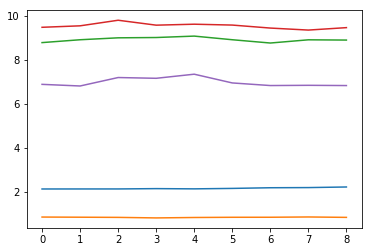

In [18]:
import matplotlib.pyplot as plt
plt.plot([results[i][0]['weights'][5:10] for i in range(9)])

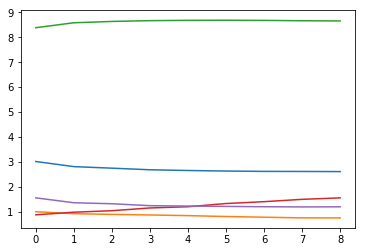

In [19]:
import matplotlib.pyplot as plt
plt.plot([results[i][1]['weights'][5:10] for i in range(9)])